In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import spacy
import re
import time
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from umap import UMAP

sys.path.append("../")

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


In [2]:
# NLP object creation :

nlp = spacy.load("en_core_web_lg", disable="ner")  # disabling NER should speed us up a bit

# nlp._config  # Checking : tok2vec is in config by default.


In [3]:
# Reading cleaned dataset, using pickle allows type preservation (spacy doc, np array etc.)

df = pd.read_pickle(filepath_or_buffer="../data/ecommerce_cleaned.pkl")


In [4]:
df.head(n=1)


,product_name,doc_desc,lem_desc,first_category,product_specifications,image,description,category_tree
0,Elegance Polyester Multicolor Abstract Eyelet ...,"(key, elegance, polyester, multicolor, abstrac...","[key, elegance, polyester, multicolor, abstrac...",home furnishing,"{""product_specification""=>[{""key""=>""Brand"", ""v...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"[Home Furnishing, Curtains & Accessories, Curt..."


# 1 : Text classification using sparse representation (Bag of Words & TF-IDF)

- We will first try to classify the products using the sparse representation of their descriptions. We will use Bag of Words (abbreviated as BoW or CV) and TF-IDF to represent the product descriptions. We will try to predict the categories using a Multinomial Naive Bayes model.
- As this approach will generate sparse vectors (vectors containing mostly zeros), we will try to apply a dimension reduction technique, UMAP, to reduce the size of the vectors to 2 components and attempt a classification on these components.
- We will evaluate the models using the average accuracy of the predictions, sklearn's classification report, and, if necessary, a confusion matrix.

<i>Note : Since we applied tokenization, stemming and lemmentazation in notebook `nb_01` and we preserved the types by using a pickle format, it is not necessary to clean the text in this notebook.</i>

## 1.1 Feature exctraction :
&emsp;We will apply CountVectorizer & TfidfVectorizer on the whole corpus first.

In [5]:
# Stopwords have already been cleaned so we dont need to add them to the vectorizer

count_vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()


In [6]:
def get_vector(row):
    """
    returns the vector of the spacy.doc object in col doc_desc
    """
    desc_doc = row["doc_desc"]
    desc_vec = desc_doc.vector
    return desc_vec


def list_to_str(row):
    """
    Turns lem_desc, a list of tokens, into a string for CV and TF-IDF usage,
    returns string
    """
    desc_list = row["lem_desc"]
    desc_txt = " ".join(desc_list)
    return desc_txt


In [7]:
df["text_vec"] = df.apply(func=get_vector, axis=1)
df["lem_desc_txt"] = df.apply(func=list_to_str, axis=1)


In [8]:
with warnings.catch_warnings():  # Storing the results of the transformation in variables for UMAP
    warnings.simplefilter('ignore')
    count_vectorizer_transform = count_vectorizer.fit_transform(df["lem_desc_txt"])
    tf_idf_transform = tf_idf_vectorizer.fit_transform(df["lem_desc_txt"])


In [9]:
# Both should be of shape (len(df), n)

print(count_vectorizer_transform.shape)
print(tf_idf_transform.shape)


(1024, 2837)
(1024, 2837)


In [10]:
df.__len__()


1024

In [11]:
# We will use Multinomial Naive Bayes so we need to encode the categories as integers and not txt:

le = LabelEncoder()
df["enc_category"] = le.fit_transform(df["first_category"])
df[["first_category", "enc_category"]].head()


,first_category,enc_category
0,home furnishing,3
1,baby care,0
2,home furnishing,3
3,home furnishing,3
4,watches,6


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df["lem_desc_txt"],
    df["enc_category"],
    test_size=0.3,
    random_state=123
    )

# The split will be common to bow & tf-idf


# 1.2 : Predictions using Bag of words and tf_idf :

## 1.2.1 : Bag of words :

In [13]:
# applying count vectorizer previously fitted on the corpus on the data :
X_train_bow = count_vectorizer.transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)


In [14]:
# Creating and fitting model :

clf = MultinomialNB()

clf.fit(X=X_train_bow, y=y_train)


MultinomialNB()

In [15]:
y_pred_bow = clf.predict(X_test_bow)

accuracy_bow = accuracy_score(y_true=y_test, y_pred=y_pred_bow)

print(accuracy_bow)


0.9025974025974026


In [16]:
inv_bow_pred = le.inverse_transform(y_pred_bow)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [17]:
print(classification_report(y_true=inv_true, y_pred=inv_bow_pred))


                                 precision    recall  f1-score   support

                      baby care       0.92      0.68      0.78        34
beauty & personal care & health       0.98      0.93      0.95        55
     home decor & festive needs       0.79      0.91      0.85        45
                home furnishing       0.79      1.00      0.88        37
               kitchen & dining       0.95      0.80      0.87        50
                     multimedia       0.98      0.98      0.98        47
                        watches       0.93      1.00      0.96        40

                       accuracy                           0.90       308
                      macro avg       0.91      0.90      0.90       308
                   weighted avg       0.91      0.90      0.90       308



#### Observations :

- The model achieves a very high average precision of 90/91%.
- It is important to note that, due to the limited amount of data (see support), the model might benefit training on a larger set of data.

In [18]:
conf_matrix_bow = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_bow_pred))
conf_matrix_bow.columns = le.inverse_transform(conf_matrix_bow.columns)
conf_matrix_bow.index = le.inverse_transform(conf_matrix_bow.index)


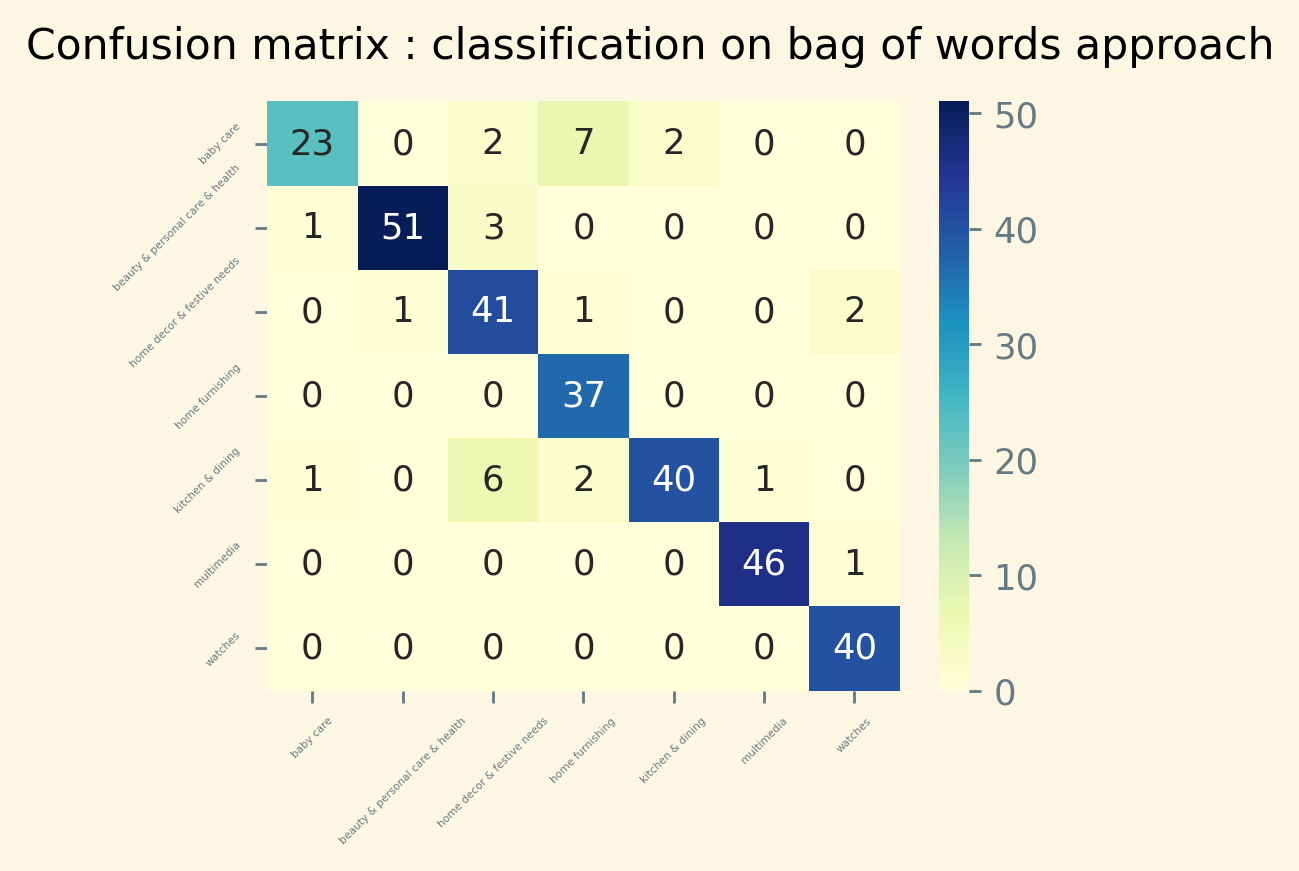

In [19]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix_bow, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification on bag of words approach")
#
###

plt.show()


#### Confusion matrix :

- This matrix shows in details what could be observed in the classification report : the model's overall performances are good but might benefit from more data.
- It's also interesting to note that there were 5 items in the "multimedia" class that were misclassified as "watches". It is logical as these two categories share a lot of technical terms. This is might be the source of the errors.

## 1.2.2 : TF-IDF 


In [20]:
X_train_tfidf = tf_idf_vectorizer.transform(X_train)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)


In [21]:
clf = MultinomialNB()

clf.fit(X=X_train_tfidf, y=y_train)


MultinomialNB()

In [22]:
y_pred_tfidf = clf.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_true=y_test, y_pred=y_pred_tfidf)

print(accuracy_tfidf)


0.922077922077922


In [23]:
inv_tfidf_pred = le.inverse_transform(y_pred_tfidf)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [24]:
print(classification_report(y_true=inv_true, y_pred=inv_tfidf_pred))


                                 precision    recall  f1-score   support

                      baby care       0.90      0.79      0.84        34
beauty & personal care & health       0.98      0.93      0.95        55
     home decor & festive needs       0.87      0.89      0.88        45
                home furnishing       0.79      1.00      0.88        37
               kitchen & dining       0.98      0.88      0.93        50
                     multimedia       1.00      0.96      0.98        47
                        watches       0.93      1.00      0.96        40

                       accuracy                           0.92       308
                      macro avg       0.92      0.92      0.92       308
                   weighted avg       0.93      0.92      0.92       308



In [25]:
conf_matrix_tfidf = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_tfidf_pred))
conf_matrix_tfidf.columns = le.inverse_transform(conf_matrix_tfidf.columns)
conf_matrix_tfidf.index = le.inverse_transform(conf_matrix_tfidf.index)


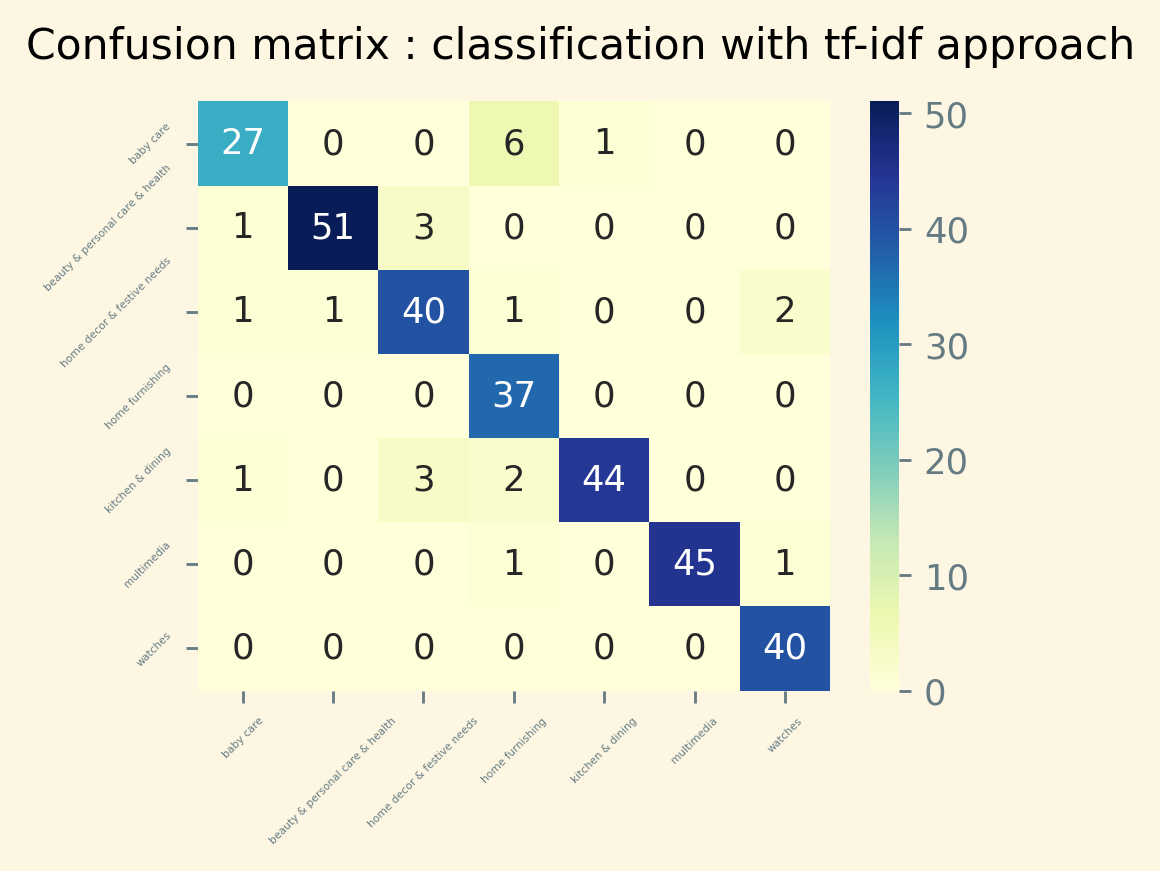

In [26]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix_tfidf, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification with tf-idf approach")
#
###

plt.show()


#### Observations :
- This model performs quite well overall, with better performance in some categories than BoW but not as well in others (e.g. baby care and home furnishing).
- We could potentially improve the model by providing it with a larger training set and using hyperparameter tuning techniques like GridSearchCV to adjust the alpha of the Multinomial Naive Bayes algorithm.

## 1.3 : UMAP on vectors from count_vectorizer and tf-idf :

- This allows to reduce the dimensions to 2838 to 2 (It is worth noting that these vectors are expected to grow with a larger dataset)
- UMAP is globally faster than T-SNE for often better results


### 1.3.1 : UMAP reduction
- Using UMAP to reduce the data into two components for each approach
- Using MinMax scaler on the data to be able to use Naive Bayes (which does not work on negative values)

In [27]:
df_reduced = df.copy()  # Separating the two datasets


In [28]:
# Dimension reduction using UMAP, settings by default, 2 components

umap = UMAP(n_components=2, n_jobs=-1)

umap_cv = umap.fit_transform(count_vectorizer_transform)
umap_tfidf = umap.fit_transform(tf_idf_transform)

print(umap_cv.shape)
print(umap_tfidf.shape)


(1024, 2)
(1024, 2)


In [29]:
# saving component 0 and 1 for CountVectorizer (umap_cv) and tf-idf (umap_tfidf)
# assigning 2 cols for each method

df_reduced["umap_cv_comp_0"] = np.nan
df_reduced["umap_cv_comp_1"] = np.nan
df_reduced["umap_tfidf_comp_0"] = np.nan
df_reduced["umap_tfidf_comp_1"] = np.nan

for index in range(0, len(df)):
    df_reduced.loc[index, "umap_cv_comp_0"] = umap_cv[index][0]
    df_reduced.loc[index, "umap_cv_comp_1"] = umap_cv[index][1]
    df_reduced.loc[index, "umap_tfidf_comp_0"] = umap_tfidf[index][0]
    df_reduced.loc[index, "umap_tfidf_comp_1"] = umap_tfidf[index][1]


In [30]:
mmx = MinMaxScaler()  # Avoiding values < 0

df_reduced["umap_cv_comp_0"] = mmx.fit_transform(df_reduced["umap_cv_comp_0"].values.reshape(-1, 1))
df_reduced["umap_cv_comp_1"] = mmx.fit_transform(df_reduced["umap_cv_comp_1"].values.reshape(-1, 1))
df_reduced["umap_tfidf_comp_0"] = mmx.fit_transform(df_reduced["umap_tfidf_comp_0"].values.reshape(-1, 1))
df_reduced["umap_tfidf_comp_1"] = mmx.fit_transform(df_reduced["umap_tfidf_comp_1"].values.reshape(-1, 1))


In [31]:
# Display original text next to reduced components for cv and tf-idf :

display_cols = [
    "lem_desc_txt", "umap_cv_comp_0", "umap_cv_comp_1",
    "umap_tfidf_comp_0", "umap_tfidf_comp_1"
    ]

display(df_reduced[display_cols])


,lem_desc_txt,umap_cv_comp_0,umap_cv_comp_1,umap_tfidf_comp_0,umap_tfidf_comp_1
0,key elegance polyester multicolor abstract eye...,0.599250,0.126830,0.338864,0.208745
1,sathiyas cotton bath towel bath towel red yell...,0.774816,0.193898,0.267493,0.148332
2,key santosh royal fashion cotton print king si...,0.738225,0.201173,0.415581,0.320931
3,key jaipur print cotton floral king size doubl...,0.738920,0.200907,0.416931,0.322484
4,maserati time analog watch boy maserati time a...,0.801087,0.949166,0.060947,0.557554
...,...,...,...,...,...
1019,empower extra large self adhesive sticker pack...,0.626190,0.097430,0.229831,0.417961
1020,wallmantra large vinyl sticker sticker pack br...,0.626447,0.100725,0.234190,0.413508
1021,uberlyfe extra large pigmented polyvinyl film ...,0.646407,0.094545,0.235379,0.406305
1022,wallmantra medium vinyl sticker sticker wallma...,0.627697,0.099227,0.238259,0.406447


#### Visualisations :

##### BoW :

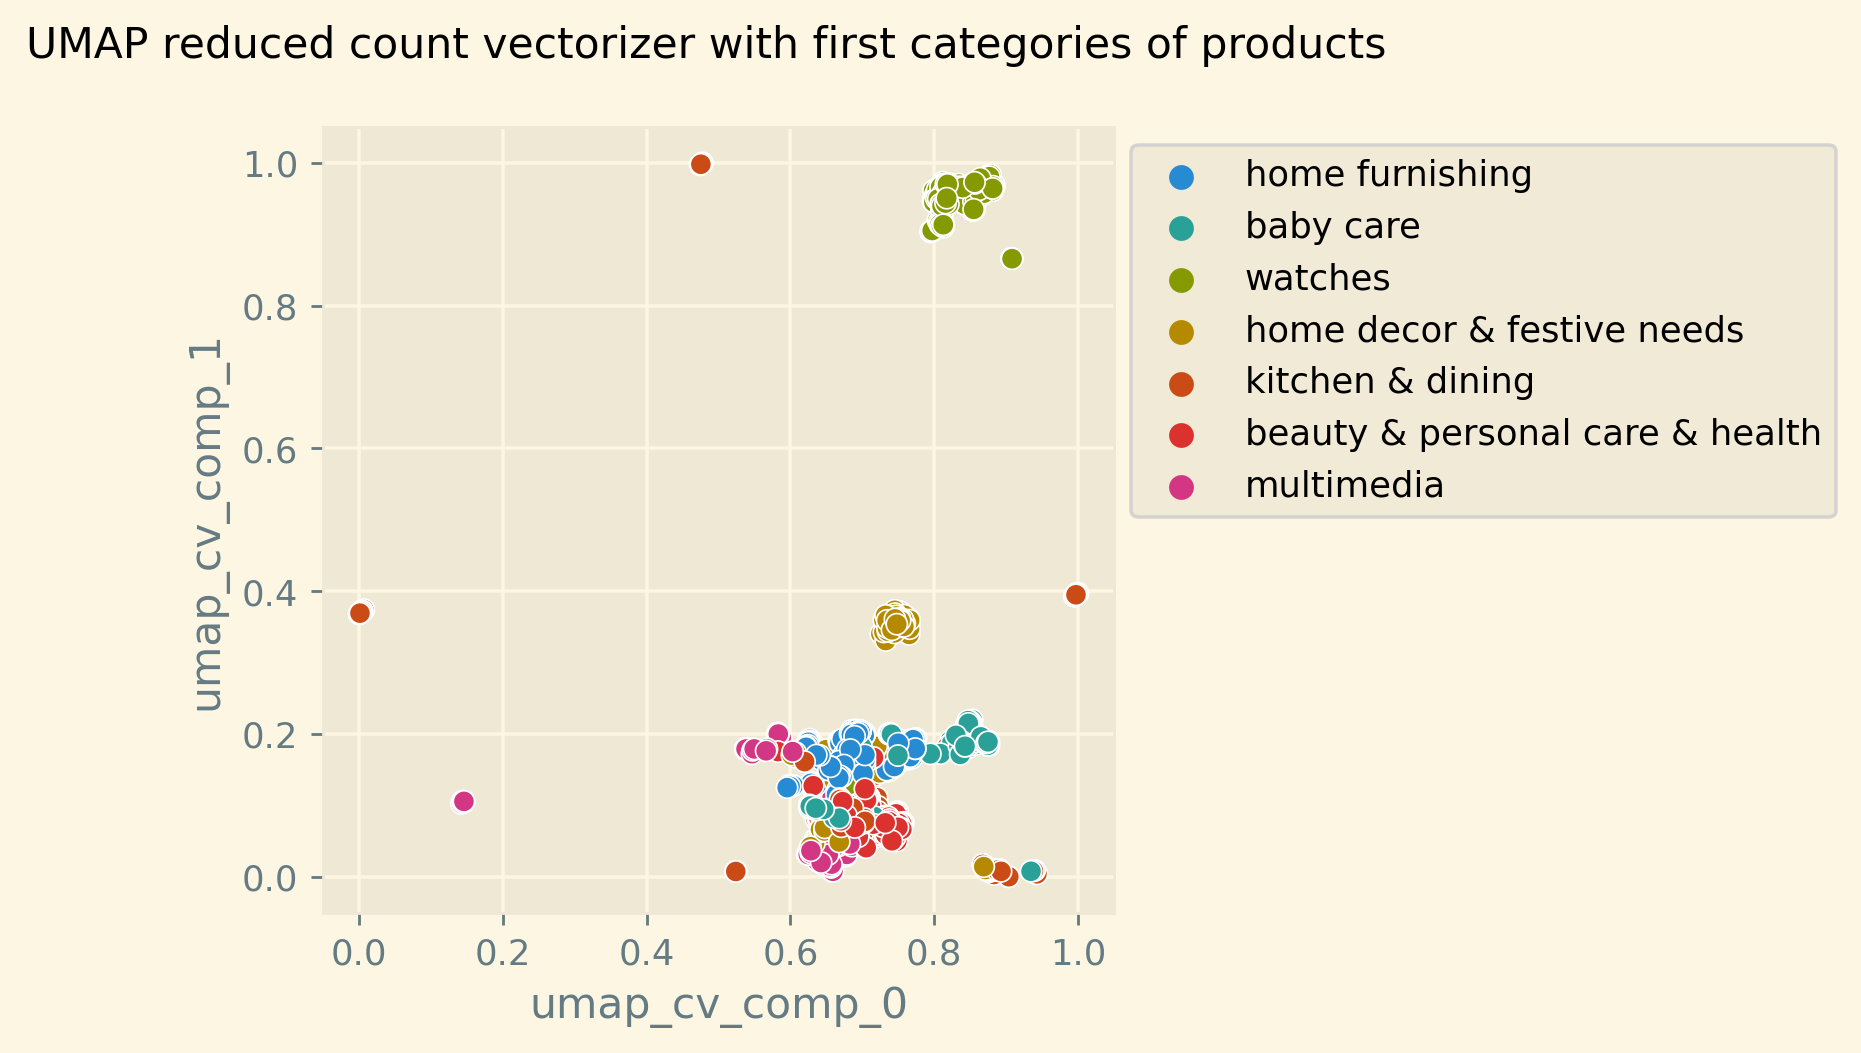

In [32]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 4),
    dpi=pc_dpi,
)

g = sns.scatterplot(data=df_reduced, x="umap_cv_comp_0", y="umap_cv_comp_1", hue="first_category", ax=ax1)

###
# Titles/Lables
sns.move_legend(
    ax1, "upper right",
    ncol=2,
    title=None,
    frameon=True,
)
plt.setp(ax1.get_legend().get_texts(), fontsize="4")
ax1.legend(bbox_to_anchor= (1,1))
fig.suptitle("UMAP reduced count vectorizer with first categories of products")
#
###

plt.show()


##### TF-IDF :

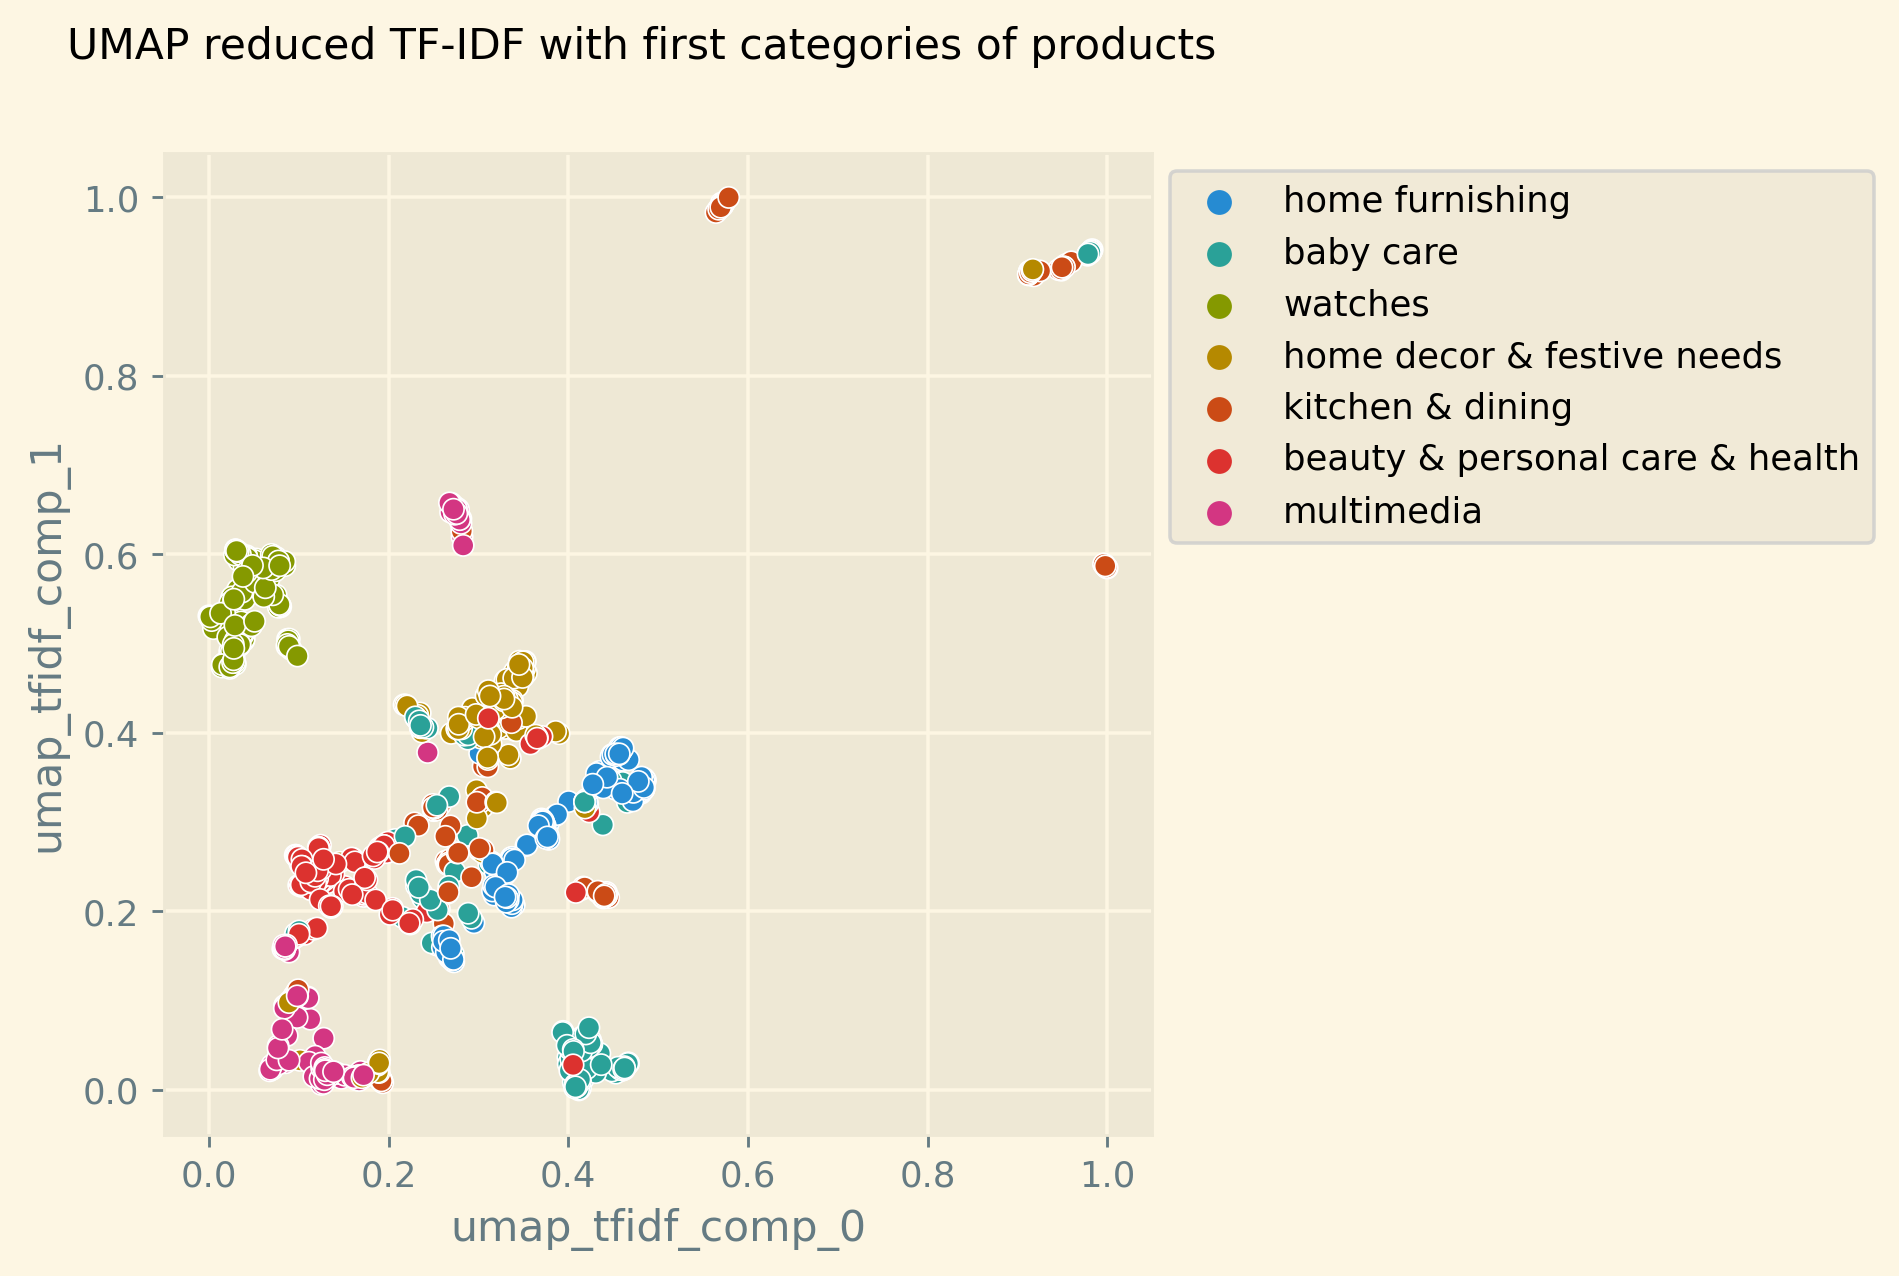

In [33]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(5, 5),
    dpi=pc_dpi,
)

g = sns.scatterplot(data=df_reduced, x="umap_tfidf_comp_0", y="umap_tfidf_comp_1", hue="first_category", ax=ax1)

###
# Titles/Lables
sns.move_legend(
    ax1, "upper right",
    ncol=2,
    title=None,
    frameon=True,
)
plt.setp(ax1.get_legend().get_texts(), fontsize="5")
ax1.legend(bbox_to_anchor=(1, 1))
fig.suptitle("UMAP reduced TF-IDF with first categories of products")
#
###

plt.show()


##### Observation :

- On both methods, the categories do not seem to exhibit major differences
- The loss of information might be too important for this approach to be relevant
- Reduction on tf-idf might be a little bit more pertinent as we see some clusters like baby care and watches isolated on the scatterplot

### 1.3.2 : Classification on Bag of Words, UMAP reduced data

In [34]:
cols_bow = ["umap_cv_comp_0", "umap_cv_comp_1", "enc_category"]

df_bow_umap = df_reduced[cols_bow]  # Creating a df for bag of words


In [35]:
X_train_bow_umap, X_test_bow_umap, y_train_bow_umap, y_test_bow_umap = train_test_split(
    df_bow_umap[["umap_cv_comp_0", "umap_cv_comp_1"]],
    df_bow_umap["enc_category"],
    test_size=0.3,
    random_state=123  # Keeping the same seed
    )


In [36]:
df_bow_umap[df_bow_umap.isna()]

,umap_cv_comp_0,umap_cv_comp_1,enc_category
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
1019,NaN,NaN,NaN
1020,NaN,NaN,NaN
1021,NaN,NaN,NaN
1022,NaN,NaN,NaN


In [37]:
clf = MultinomialNB()

clf.fit(X_train_bow_umap, y_train_bow_umap)

predictions = clf.predict(X_test_bow_umap)


In [38]:
accuracy_bow_umap = accuracy_score(y_true=y_test_bow_umap, y_pred=predictions)

print(accuracy_bow_umap)


0.24025974025974026


In [39]:
# Ok that seems bad, let's try a confusion matrix
conf_matrix = confusion_matrix(y_test_bow_umap, predictions)

confusion_matrix_df_bow_umap = pd.DataFrame(data=conf_matrix)


In [40]:
display(confusion_matrix_df_bow_umap)


,0,1,2,3,4,5,6
0,34,0,0,0,0,0,0
1,55,0,0,0,0,0,0
2,15,0,0,30,0,0,0
3,37,0,0,0,0,0,0
4,31,0,0,8,0,0,11
5,47,0,0,0,0,0,0
6,0,0,0,0,0,0,40


##### Observation :

- Overall, the loss of information during UMAP reduction seems to be too large for the model to be precise, with an accuracy of only 24.4%. It is likely that much of the variance was lost during the dimension reduction process, making it difficult for the classification model to be relevant on BoW.

### 1.3.2 : Classification on TF-IDF, UMAP reduced data

In [41]:
cols_tf_idf = ["umap_tfidf_comp_0", "umap_tfidf_comp_1", "enc_category"]

df_tf_idf_umap = df_reduced[cols_tf_idf]  # Creating a df for tf-idf


In [42]:
X_train_tfidf_umap, X_test_tfidf_umap, y_train_tfidf_umap, y_test_tfidf_umap = train_test_split(
    df_tf_idf_umap[["umap_tfidf_comp_0", "umap_tfidf_comp_1"]],
    df_tf_idf_umap["enc_category"],
    test_size=0.3,
    random_state=123  # same seed
    )


In [43]:
clf = MultinomialNB()

clf.fit(X_train_tfidf_umap, y_train_tfidf_umap)

predictions = clf.predict(X_test_tfidf_umap)


In [44]:
accuracy_tfidf_umap = accuracy_score(y_true=y_test_tfidf_umap, y_pred=predictions)

print(accuracy_tfidf_umap)


0.3181818181818182


In [45]:
conf_matrix = confusion_matrix(y_test_tfidf_umap, predictions)

confusion_matrix_df_umap = pd.DataFrame(data=conf_matrix)

display(confusion_matrix_df_umap)


,0,1,2,3,4,5,6
0,24,0,0,10,0,0,0
1,0,0,0,55,0,0,0
2,2,0,0,43,0,0,0
3,3,0,0,34,0,0,0
4,13,0,8,29,0,0,0
5,26,0,11,10,0,0,0
6,0,0,0,0,0,0,40


##### Observation :

- Based on the confusion matrix and the reported accuracy of 14.4%, it looks like the model is not performing well. Most of the predictions made by the model are incorrect, with a high number of false positives and false negatives.
- The dimensional reduction might be to blame for the poor performance of the model. We should consider discarding the dimensional reduction approach in order to improve the model's performance.

In [46]:
del df_bow_umap
del df_tf_idf_umap
del accuracy_bow_umap
del accuracy_tfidf_umap
# Frees a bit of memory


# 1.4 : Conclusion on BoW and TF-IDF

- Dimensional reduction is not efficient in this case, the loss of information seems to be too large.
- Both unreduced models, however, seems to perform quite well. As explained in both cases, we could benefit from a larger sample of data but, from the informations we have, both models could be used, bag of words seems to be more accurate overall but it might depend on the training.
- It is important to remember that the number of descriptions directly affects the length of the vectors generated by these approaches. As the number of descriptions increases, it is highly likely that the size of the matrices (which are linked to the size of the corpus' vocabulary) will grow, potentially negatively impacting the model's performance in terms of speed and memory usage.
<br><br><hr><br>
- Using word and sentence embedding might lead to better performances and better results.

# 2 : Word embedding :

&emsp;In the context of text classification, word embedding can be a pretty potent method over BoW and TF-IDF methods :
- Word embedding captures the semantic meaning of a word (if the model is well-trained), which, in the context of product classification, might present some advantages.
- It also presents the advantage of being a "dense" method, compared to BoW and TF-IDF which are "sparse" methods. Our corpus is quite small, but we can see that the BoW and TF-IDF vectors are very long (2838), but still manageable. If we want to upscale these methods, it would mean that these vectors would be as long as there are unique terms in the dataset, which would present a big computational and size issue. As word embedding represents a word in a vector of size (usually) 300, upscaling wouldn't be such of a problem.

<i>In a context where the dataset would be a much bigger sample, we could create our own word embedding model. However, since we have only 1048 product descriptions, creating a model based on this data might not be relevant enough, so we will use a pretrained model instead. It might be more accurate with more data or with a training dataset using only e-commerce data.</i>

## 2.1 : Selection of the model

&emsp;We have a lot of options (Google's word2vec on Google News, Stanford's GloVe on Wikipedia and Meta's Fasttext). These models are quite heavy (around 1Gb) but contain a lot of informations. Google's model is the largest but Fasttest can also be interesting to use as it is trained on Wikipedia's corpus.

- We will use two classification methods for each model :
    - ensemble.GradientBoostingClassifier
    - linear_model.LogisticRegression (with CV)

- We have saved <b>word2vec</b> and <b>FastText</b> into the folder "`heavy/`" as .h5 (to (re)run the download, use this notebook : `gensim_downloader.ipynb`)
- We can use `gensim.models.KeyedVectors` to load these files :

In [47]:
wv_model = KeyedVectors.load(fname="../heavy/word2vec.h5")
ft_model = KeyedVectors.load(fname="../heavy/fast_text.h5")


In [48]:
# checking the loading was made correctly

print(wv_model.__len__())
print(ft_model.__len__())


3000000
999999


In [49]:
# Let's make a copy of the dataframe with only the required columns :

subset = ["lem_desc_txt", "first_category", "enc_category"]

df_embed = df[subset].copy()

In [50]:
df_embed.head()


,lem_desc_txt,first_category,enc_category
0,key elegance polyester multicolor abstract eye...,home furnishing,3
1,sathiyas cotton bath towel bath towel red yell...,baby care,0
2,key santosh royal fashion cotton print king si...,home furnishing,3
3,key jaipur print cotton floral king size doubl...,home furnishing,3
4,maserati time analog watch boy maserati time a...,watches,6


## 2.2 : Word2Vec :


In [51]:
# Creation of embedding function :

def word_to_vec_embed(row):
    """
    Splits row["lem_desc_txt"] and returns the mean
    vector of this list using word2vec model.
    """
    list_txt = row["lem_desc_txt"]
    return wv_model.get_mean_vector(list_txt)



In [52]:
df_embed["wordtovec"] = df_embed.apply(word_to_vec_embed, axis=1)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df_embed["wordtovec"],
    df_embed["enc_category"],
    test_size=0.3,
    random_state=123  # Same seed
)


In [54]:
X_train_stacked = np.stack(X_train)  # To 2D arr
X_test_stacked = np.stack(X_test)  # To 2D arr

print(X_train_stacked.shape, X_test_stacked.shape)


(716, 300) (308, 300)


### 2.2.1 : Logistic Regression :

In [55]:
param_grid = {'C': range(90, 110, 1)}  # Trial and error, around 100 works the best, 96 in this case

grid_logistic_regression = GridSearchCV(
    estimator=LogisticRegression(solver="lbfgs", max_iter=500),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)


In [56]:
grid_logistic_regression.fit(X_train_stacked, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500), n_jobs=-1,
             param_grid={'C': range(90, 110)}, scoring='accuracy')

In [57]:
print(grid_logistic_regression.best_params_)

lr = grid_logistic_regression.best_estimator_


{'C': 90}


In [58]:
# refitting, just in case :

lr.fit(X_train_stacked, y_train)


LogisticRegression(C=90, max_iter=500)

In [59]:
y_pred_w2v_lr = lr.predict(X_test_stacked)

accuracy_w2v_lr = accuracy_score(y_true=y_test, y_pred=y_pred_w2v_lr)

print(accuracy_w2v_lr)


0.6363636363636364


In [60]:
inv_y_pred_w2v_lr = le.inverse_transform(y_pred_w2v_lr)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [61]:
# ok thats a bit disappointing, let's take a closer look :

print(classification_report(y_true=inv_true, y_pred=inv_y_pred_w2v_lr))


                                 precision    recall  f1-score   support

                      baby care       0.50      0.65      0.56        34
beauty & personal care & health       0.74      0.64      0.69        55
     home decor & festive needs       0.55      0.64      0.59        45
                home furnishing       0.52      0.62      0.57        37
               kitchen & dining       0.67      0.62      0.65        50
                     multimedia       0.67      0.43      0.52        47
                        watches       0.82      0.90      0.86        40

                       accuracy                           0.64       308
                      macro avg       0.64      0.64      0.63       308
                   weighted avg       0.65      0.64      0.63       308



#### Observation :

&emsp;It seems that word2vec is less performant than BoW and TF-IDF. It scores relatively high in some categories (e.g. watches), but performs poorly on other (like baby care). <br>
&emsp;We can display a confusion matrix to identify where the errors come from :

In [62]:
conf_matrix_w2v_lr = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_pred_w2v_lr))
conf_matrix_w2v_lr.columns = le.inverse_transform(conf_matrix_w2v_lr.columns)
conf_matrix_w2v_lr.index = le.inverse_transform(conf_matrix_w2v_lr.index)


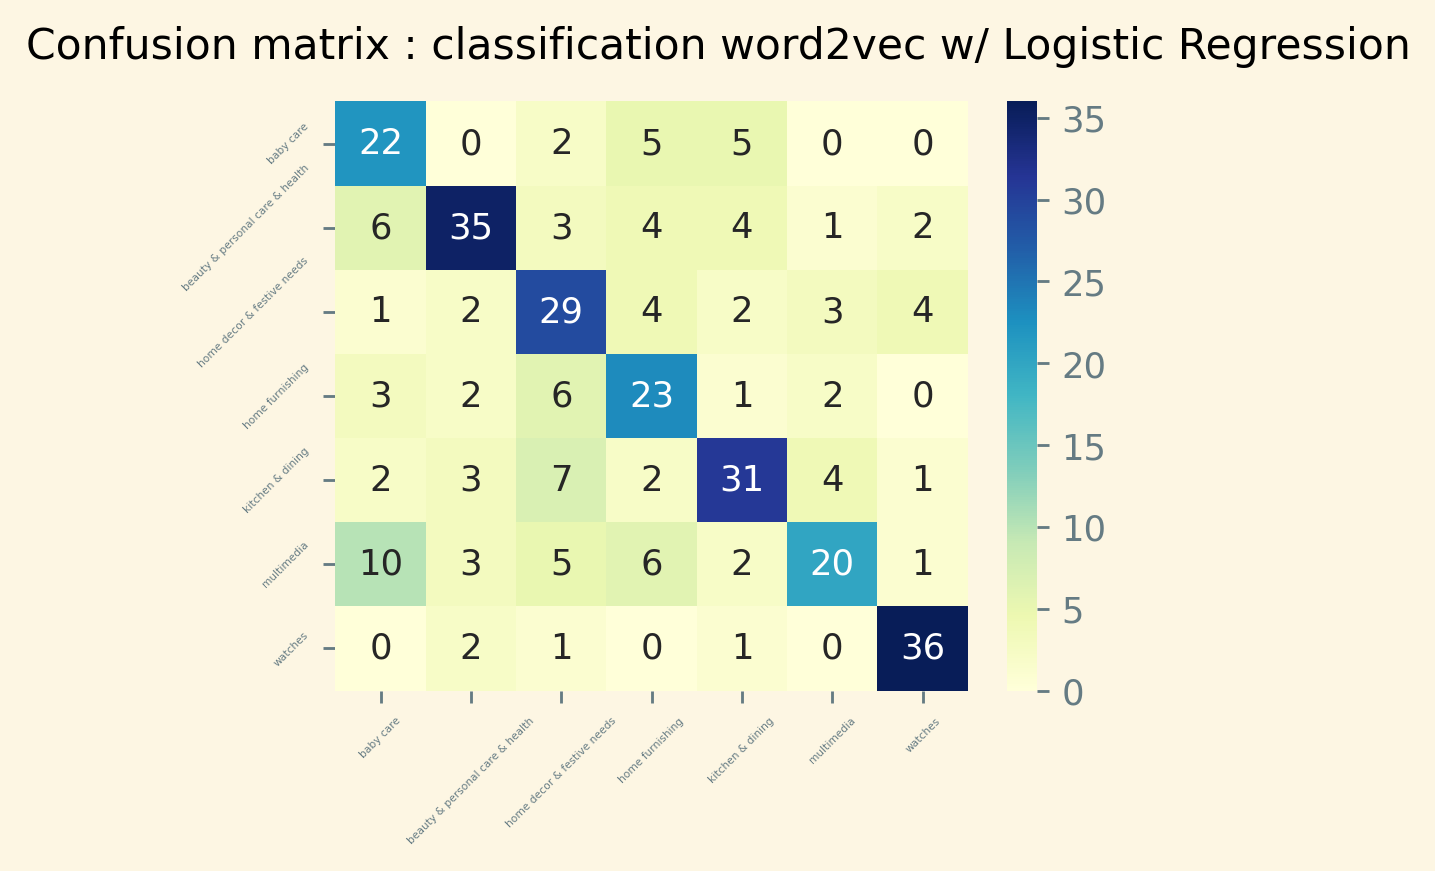

In [63]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix_w2v_lr, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification word2vec w/ Logistic Regression")
#
###

plt.show()


#### Confusion matrix :

&emsp;We can see that there are many more misclassifications with the dense method compared to the sparse methods. "Baby care" in particular is often mislabeled as "multimedia," which can be explained by the fact that many items in this category are digital monitoring systems that may share a lot of common words with multimedia descriptions.

### 2.2.2 : Gradient Boost Classifier 

In [64]:
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 4, 5]
#     }


# grid_gbc = GridSearchCV(
#     GradientBoostingClassifier(loss="log_loss"),
#     param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1
#     )



In [65]:
# tzero = time.perf_counter()  # ~10mns

# grid_gbc.fit(X_train_stacked, y_train)

# tf = time.perf_counter()

# print(f"Execution time : {tf - tzero} s")

# grid_gbc.best_params_

##### The code above is commented out to avoid long runtimes, best params have been found to be : {'max_depth': 3, 'n_estimators': 200}, need to potentially adapt if the data changes

In [66]:
tzero = time.perf_counter()

gb_clf = GradientBoostingClassifier(
    loss="log_loss",
    n_estimators=200,
    max_depth=3,
)

gb_clf.fit(X_train_stacked, y_train)

tf = time.perf_counter()

print(f"Execution time : {tf - tzero}")


Execution time : 48.783952750003664


In [67]:
y_pred_w2v_gb = gb_clf.predict(X_test_stacked)

accuracy_w2v_gb = accuracy_score(y_true=y_test, y_pred=y_pred_w2v_gb)

print(accuracy_w2v_gb)


0.7012987012987013


In [68]:
inv_y_pred_w2v_gb = le.inverse_transform(y_pred_w2v_gb)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [69]:
# Ensemble methods generally benefit from larger datasets, that could be a lead
# for the overall lack of accuracy, let's check the detailed results :

print(classification_report(y_true=inv_true, y_pred=inv_y_pred_w2v_gb))


                                 precision    recall  f1-score   support

                      baby care       0.63      0.65      0.64        34
beauty & personal care & health       0.71      0.73      0.72        55
     home decor & festive needs       0.59      0.71      0.65        45
                home furnishing       0.53      0.62      0.57        37
               kitchen & dining       0.85      0.66      0.74        50
                     multimedia       0.76      0.66      0.70        47
                        watches       0.88      0.88      0.88        40

                       accuracy                           0.70       308
                      macro avg       0.71      0.70      0.70       308
                   weighted avg       0.71      0.70      0.70       308



#### Observation :

&emsp;Gradient Boost Classifier is more relevant than Logistic Regression in this case, but it is still less precise than sparse methods. It might be interesting to use this method on a larger sample of data, as ensemble methods generally benefit from larger datasets. <br>
&emsp;It is also worth noting that the learning time of this algorithm is longer than the other used in this notebook. It might prove challenging to upscale correctly. <br>
&emsp;This method is overall acceptable, less performant than BoW, for example but it might prove more relevant with more data.

In [70]:
conf_matrix_w2v_gb = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_pred_w2v_gb))
conf_matrix_w2v_gb.columns = le.inverse_transform(conf_matrix_w2v_gb.columns)
conf_matrix_w2v_gb.index = le.inverse_transform(conf_matrix_w2v_gb.index)


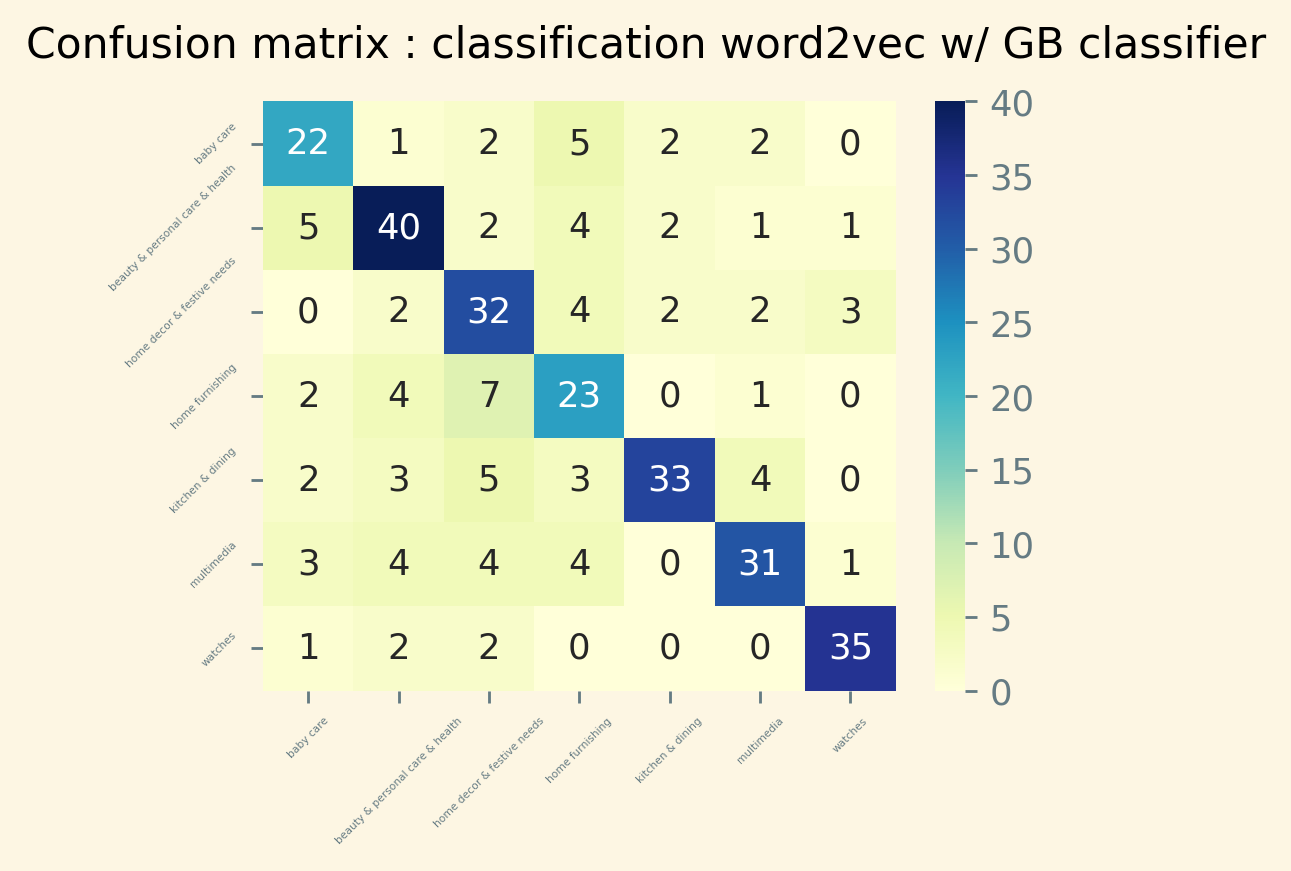

In [71]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix_w2v_gb, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification word2vec w/ GB classifier")
#
###

plt.show()


#### Confusion matrix :
&emsp;While averaging 70% accuracy, we can clearly see that this model underperforms compared to BoW. It is still more accurate than LR. It might be interesting to see what the performances might be with a larger sample

#### Word2Vec, conclusion :

&emsp;While the overall results are not as good as sparse methods, Gradient Boost Classifier looks promising. In our case, with a limited corpus, the Google News vectors might not be really adapted for e-commerce usage as the contexts might differ a lot. It is worth looking at another pretrained word embedding method trained on more generic data : Meta's FastTest.

### 2.3 : FastText

In [72]:
# Creation of embedding function :

def fast_text_embed(row):
    """
    Splits row["lem_desc_txt"] and returns the mean
    vector of this list using FastTex.
    """
    list_txt = row["lem_desc_txt"]
    return ft_model.get_mean_vector(list_txt)


In [73]:
df_embed["fasttext"] = df_embed.apply(func=fast_text_embed, axis=1)

df_embed.head()

,lem_desc_txt,first_category,enc_category,wordtovec,fasttext
0,key elegance polyester multicolor abstract eye...,home furnishing,3,"[-0.067938365, 0.04405869, -0.0067764847, 0.05...","[0.0097690625, -0.027335681, 0.037145775, 0.03..."
1,sathiyas cotton bath towel bath towel red yell...,baby care,0,"[-0.06887503, 0.04835953, -0.011344197, 0.0491...","[0.010257866, -0.029215029, 0.03656009, 0.0391..."
2,key santosh royal fashion cotton print king si...,home furnishing,3,"[-0.06697452, 0.046503864, -0.0053308783, 0.05...","[0.008497985, -0.027674703, 0.038901664, 0.041..."
3,key jaipur print cotton floral king size doubl...,home furnishing,3,"[-0.06687755, 0.04484054, -0.0064179837, 0.051...","[0.008372302, -0.02735008, 0.03859091, 0.04286..."
4,maserati time analog watch boy maserati time a...,watches,6,"[-0.07398824, 0.039339095, -0.009490126, 0.054...","[0.009232101, -0.024664449, 0.03196324, 0.0337..."


In [74]:
X_train_ft, X_test_ft, y_train, y_test = train_test_split(
    df_embed["fasttext"],
    df_embed["enc_category"],
    test_size=0.3,
    random_state=123  # Same seed
)


In [75]:
X_train_stacked_ft = np.stack(X_train_ft)  # To 2D arr
X_test_stacked_ft = np.stack(X_test_ft)  # To 2D arr

print(X_train_stacked_ft.shape, X_test_stacked_ft.shape)


(716, 300) (308, 300)


### 2.3.1 : Logistic regression

In [76]:
param_grid = {'C': range(180, 200, 1)}  # Trial and error, around 190 works the best

grid_logistic_regression = GridSearchCV(
    estimator=LogisticRegression(solver="lbfgs", max_iter=500),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)


In [77]:
grid_logistic_regression.fit(X_train_stacked_ft, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500), n_jobs=-1,
             param_grid={'C': range(180, 200)}, scoring='accuracy')

In [78]:
print(grid_logistic_regression.best_params_)

lr = grid_logistic_regression.best_estimator_


{'C': 185}


In [79]:
lr.fit(X_train_stacked_ft, y_train)


LogisticRegression(C=185, max_iter=500)

In [80]:
y_pred_ft_lr = lr.predict(X_test_stacked)

accuracy_ft_lr = accuracy_score(y_true=y_test, y_pred=y_pred_ft_lr)

print(accuracy_ft_lr)


0.17857142857142858


In [81]:
# Ok so thats really bad, lets use the classification report :

inv_y_pred_ft_lr = le.inverse_transform(y_pred_ft_lr)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [82]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_pred_ft_lr))


                                 precision    recall  f1-score   support

                      baby care       0.00      0.00      0.00        34
beauty & personal care & health       0.18      1.00      0.30        55
     home decor & festive needs       0.00      0.00      0.00        45
                home furnishing       0.00      0.00      0.00        37
               kitchen & dining       0.00      0.00      0.00        50
                     multimedia       0.00      0.00      0.00        47
                        watches       0.00      0.00      0.00        40

                       accuracy                           0.18       308
                      macro avg       0.03      0.14      0.04       308
                   weighted avg       0.03      0.18      0.05       308



#### Observation : 
&emsp;This model is really bad, it fails practically everywhere, it might be argued that classifying at random might yield the same result. Despite HP tuning it seems that this model does not work well on this dataset. There is no need to plot a confusion matrix in this case, most of the data has been mislabelled.

### 2.3.2 : Gradient Boost Classifier

In [83]:
# param_grid = {
#     "n_estimators": [500, 600, 700],
#     "max_depth": [3]  # Already determined
#     }


# grid_gbc = GridSearchCV(
#     GradientBoostingClassifier(loss="log_loss"),
#     param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1
#     )


In [84]:
# tzero = time.perf_counter()  # ~10mns

# grid_gbc.fit(X_train_stacked_ft, y_train)

# tf = time.perf_counter()

# print(f"Execution time : {tf - tzero} s")

# print(grid_gbc.best_params_)


##### The code above is commented out to avoid long runtimes, best params have been found to be : {'max_depth': 3, 'n_estimators': 700}, need to potentially adapt if the data changes (potentially more than 700 but training time is going sky high)

In [85]:
tzero = time.perf_counter()

gb_clf = GradientBoostingClassifier(
    loss="log_loss",
    n_estimators=700,
    max_depth=3,
)

gb_clf.fit(X_train_stacked_ft, y_train)

tf = time.perf_counter()

print(f"Execution time : {tf - tzero}")


Execution time : 151.53484091701102


In [86]:
y_pred_ft_gb = gb_clf.predict(X_test_stacked)

accuracy_ft_gb = accuracy_score(y_true=y_test, y_pred=y_pred_ft_gb)

print(accuracy_ft_gb)


0.16883116883116883


In [87]:
# Ok so another bad result here. Let's bring up the
# Classification report :
inv_y_pred_ft_gb = le.inverse_transform(y_pred_ft_gb)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [88]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_pred_ft_gb))


                                 precision    recall  f1-score   support

                      baby care       0.00      0.00      0.00        34
beauty & personal care & health       0.67      0.22      0.33        55
     home decor & festive needs       0.00      0.00      0.00        45
                home furnishing       0.00      0.00      0.00        37
               kitchen & dining       0.09      0.02      0.03        50
                     multimedia       0.14      0.83      0.24        47
                        watches       0.00      0.00      0.00        40

                       accuracy                           0.17       308
                      macro avg       0.13      0.15      0.09       308
                   weighted avg       0.16      0.17      0.10       308



#### Observations :

&emsp;It seems that FastText is underperforming a lot, compared to word2vec and the sparse approaches. The model might not be relevant as it is my understanding that FastText is better on tasks such as sentiment analysis.

### Conclusion on Word Embeddings :
&emsp;While we can immediately discard the approach using FastText, it is important to note that the performances achieved by word2vec with Gradient Boost classifier were quite convincing considering the limited size of the dataset. <br>
&emsp;The lack of accuracy in these methods compared to the sparse methods seen in part 1 might come from different factors :
- The model was not directly related to e-commerce in both cases and might have resulted in poorly adapted vectors for this use case.
- The corpus was not large enough for ensemble methods to perform at their full potential, this can be solved by using a larger dataset (it is important to note that computation time are very high in these case)
- Training a model on this corpus would have likely resulted on poor results considering the lack of overall data.


<hr>
<br>
&emsp;If word embedding techniques are to be exploited to their fullest, we might want to consider either training a model on the entire client's database or resort to webscrapping websites like Amazon or Ebay and train on these datasets.